In [2]:
using QuantumDynamics
using Plots
using LinearAlgebra

Hoping to get rid of the units issue by integrating Unitful into QuantumDynamics package.

In [3]:
const thz2au = 0.0001519828500716
const invcm2au = 4.55633e-6
const au2fs = 0.02418884254
const mev2invcm = 8.066
const nm2au = 18.897

18.897

In [4]:
struct fitsd <: SpectralDensities.AnalyticalSpectralDensity
    ωs :: Vector{Float64}
    jws :: Vector{Float64}
    ωmax :: Real
    Δs :: Real
    classical :: Bool
end

Gaussian broadening distribution

In [5]:
σ = 10*invcm2au
function evaluate(sd::fitsd, ω::Real)
    ωs = sd.ωs
    jws = sd.jws
    
    s = 0.0
    for i in 1:(size(ωs)[1])
        s += jws[i]*exp(-(((ω-ωs[i])/σ)^2))
    end
    s
end

evaluate (generic function with 1 method)

In [6]:
function discretize(sd::fitsd, num_osc::Int)
    return sd.ωs, (sd.jws.^(0.5))
end

discretize (generic function with 1 method)

In [7]:
(sd::fitsd)(ω::Real) = evaluate(sd, ω)

In [8]:
ϵ0 = 0 # This appears to not change the dynamics at all
ϵb = 300*invcm2au

0.0013668990000000002

In [21]:
N = 4

4

In [22]:
H0 = Matrix{ComplexF64}(zeros(N, N))

4×4 Matrix{ComplexF64}:
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im

In [23]:
for i in 1:N
    H0[i,i] = ϵ0
    if i <= N-1
        H0[i, i+1] = ϵb
    end
    if i >= 2
        H0[i, i-1] = ϵb
    end
end
H0

In [25]:
#ωp = [265.6, 823.7, 1054.6, 1195.4, 1234.5, 1443.2, 1572.8] .* invcm2au
#g0p = [107.0, -126.0, -178.2, -246.2, -467.9, 819.7, 761.2] .* invcm2au
#jws = (g0p.^(2))
#wm = maximum(ωp)
Jw = SpectralDensities.DrudeLorentz(λ=100*invcm2au, γ=50*invcm2au, Δs=1.0)

QuantumDynamics.SpectralDensities.DrudeLorentz(0.00045563300000000005, 0.00022781650000000002, 1.0, 0.22781650000000003, false)

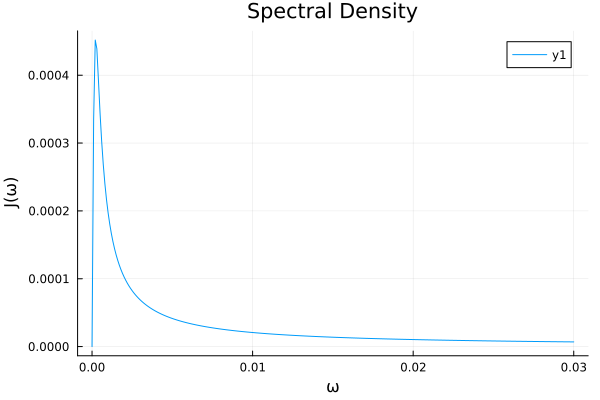

In [26]:
ω = 0:0.0001:0.03
plot(ω, Jw.(ω), xlabel="ω", ylabel="J(ω)", title="Spectral Density")

In [27]:
nsteps = 50
ρ0 = Matrix{ComplexF64}(zeros(N, N))
ρ0[1, 1] = 1

T = 50.0:50.0:500.0

β = 1 / (T[6] * 3.16683e-6) # T = 300K

1052.5772881188234

Simulation is very sensitive to time-stepping. NaNs get produced if you're not careful

In [28]:
dt = 20/au2fs

826.8274915150198

In [29]:
#fbU = Propagators.calculate_bare_propagators(; Hamiltonian=H0, dt=dt, ntimes=nsteps)    
#t, ρ = TTM.propagate(; fbU=fbU, Jw=[Jw], β=β, ρ0=ρ0, dt=dt, ntimes=nsteps, rmax=1, extraargs=QuAPI.QuAPIArgs(), path_integral_routine=QuAPI.build_augmented_propagator)

In [30]:
d = 0.05 * nm2au 

0.94485

In [31]:
## QCPI Run

ω, c = SpectralDensities.discretize(Jw, 100)
hb = Solvents.HarmonicBath(β, ω, c, [1.0, 2.0, 3.0, 4.0].*d, 1000)
tc, ρc = QCPI.propagate(; Hamiltonian=H0, Jw, solvent=hb, ρ0, classical_dt=dt / 100, dt, ntimes=nsteps, kmax=1, svec=[1.0 2.0 3.0 4.0].*d, extraargs=QuAPI.QuAPIArgs(), path_integral_routine=QuAPI.propagate)

(0.0:826.8274915150198:41341.37457575099, [1.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im; 0.24221986165398973 + 0.0im -0.10204102472301874 - 0.3286451081485143im -0.12655684859846308 + 0.1571576924518301im 0.07552224642859957 - 0.012871411949572241im; … ; 0.3989229814667996 + 2.5295691278499824e-19im -0.5576221121637076 + 0.03322866865535791im 0.4160897573487004 - 0.039520586364504603im -0.2202497506796641 + 0.03817993132289304im; 0.44194635105456864 - 3.299182303816841e-18im -0.569050013208158 + 0.00463306047009095im 0.43932889707548667 - 0.03061292605820195im -0.23704301828092356 + 0.030353023130151157im;;; 0.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im; -0.10204102472301874 + 0.3286451081485143im 0.5179872437160459 + 0.0im -0.17758947095383618 - 0.26435877353672904im -0.01719721201045329 + 0.1258663522170505im; … ; -0.5576221121637075 - 0.033228668655357896im 0.5703516491299655 - 1.0586378000563416e-17im -0.2650092077332122 + 0.02044466085414408im 0.07829461500714151 - 0.01075336

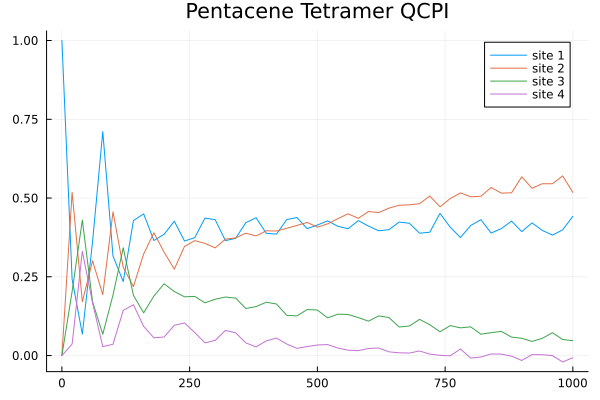

In [32]:
plot(tc.*au2fs, real.(ρc[:, 1, 1]), label="site 1")
plot!(tc.*au2fs, real.(ρc[:, 2, 2]), label="site 2")
plot!(tc.*au2fs, real.(ρc[:, 3, 3]), label="site 3")
plot!(tc.*au2fs, real.(ρc[:, 4, 4]), label="site 4", title="Pentacene Tetramer QCPI")